In [5]:
INPUT_DIRECTORY = "../dataset"
OUTPUT_DIRECTORY = "../output"
MODEL_DIRECTORY = "../model"
CREDENTIALS_DIRECTORY = "../config"

In [6]:
import os
import base64
import requests
import numpy as np
import pandas as pd
import itertools
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn import metrics
from sklearn import preprocessing
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import confusion_matrix
from sklearn.model_selection import train_test_split
from keras.models import Sequential
from keras.layers.core import Dense, Activation
from keras.layers import Dropout
from keras.callbacks import EarlyStopping
from sklearn.metrics import confusion_matrix
from sklearn.metrics import precision_score,recall_score,f1_score,roc_auc_score,accuracy_score,classification_report

In [7]:
# Encode text values to dummy variables(i.e. [1,0,0],[0,1,0],[0,0,1] for red,green,blue)
def encode_text_dummy(df, name):
    dummies = pd.get_dummies(df[name])
    for x in dummies.columns:
        dummy_name = f"{name}-{x}"
        df[dummy_name] = dummies[x]
    df.drop(name, axis=1, inplace=True)


# Encode text values to a single dummy variable.  The new columns (which do not replace the old) will have a 1
# at every location where the original column (name) matches each of the target_values.  One column is added for
# each target value.
def encode_text_single_dummy(df, name, target_values):
    for tv in target_values:
        l = list(df[name].astype(str))
        l = [1 if str(x) == str(tv) else 0 for x in l]
        name2 = f"{name}-{tv}"
        df[name2] = l


# Encode text values to indexes(i.e. [1],[2],[3] for red,green,blue).
def encode_text_index(df, name):
    le = preprocessing.LabelEncoder()
    df[name] = le.fit_transform(df[name])
    return le.classes_


# Encode a numeric column as zscores
def encode_numeric_zscore(df, name, mean=None, sd=None):
    if mean is None:
        mean = df[name].mean()

    if sd is None:
        sd = df[name].std()

    df[name] = (df[name] - mean) / sd


# Convert all missing values in the specified column to the median
def missing_median(df, name):
    med = df[name].median()
    df[name] = df[name].fillna(med)


# Convert all missing values in the specified column to the default
def missing_default(df, name, default_value):
    df[name] = df[name].fillna(default_value)


# Convert a Pandas dataframe to the x,y inputs that TensorFlow needs
def to_xy(df, target):
    result = []
    for x in df.columns:
        if x != target:
            result.append(x)
    # find out the type of the target column.  Is it really this hard? :(
    target_type = df[target].dtypes
    target_type = target_type[0] if hasattr(
        target_type, '__iter__') else target_type
    # Encode to int for classification, float otherwise. TensorFlow likes 32 bits.
    if target_type in (np.int64, np.int32):
        # Classification
        dummies = pd.get_dummies(df[target])
        return df[result].values.astype(np.float32), dummies.values.astype(np.float32)
    # Regression
    return df[result].values.astype(np.float32), df[[target]].values.astype(np.float32)

# Nicely formatted time string
def hms_string(sec_elapsed):
    h = int(sec_elapsed / (60 * 60))
    m = int((sec_elapsed % (60 * 60)) / 60)
    s = sec_elapsed % 60
    return f"{h}:{m:>02}:{s:>05.2f}"


# Regression chart.
def chart_regression(pred, y, sort=True):
    t = pd.DataFrame({'pred': pred, 'y': y.flatten()})
    if sort:
        t.sort_values(by=['y'], inplace=True)
    plt.plot(t['y'].tolist(), label='expected')
    plt.plot(t['pred'].tolist(), label='prediction')
    plt.ylabel('output')
    plt.legend()
    plt.show()

# Remove all rows where the specified column is +/- sd standard deviations
def remove_outliers(df, name, sd):
    drop_rows = df.index[(np.abs(df[name] - df[name].mean())
                          >= (sd * df[name].std()))]
    df.drop(drop_rows, axis=0, inplace=True)


# Encode a column to a range between normalized_low and normalized_high.
def encode_numeric_range(df, name, normalized_low=-1, normalized_high=1,
                         data_low=None, data_high=None):
    if data_low is None:
        data_low = min(df[name])
        data_high = max(df[name])

    df[name] = ((df[name] - data_low) / (data_high - data_low)) \
        * (normalized_high - normalized_low) + normalized_low

    
# Helper functions
def expand_categories(values):
    result = []
    s = values.value_counts()
    t = float(len(values))
    for v in s.index:
        result.append("{}:{}%".format(v,round(100*(s[v]/t),2)))
    return "[{}]".format(",".join(result))
        
def analyze(filename):
    print()
    print("Analyzing: {}".format(filename))
    df = pd.read_csv(filename,encoding=ENCODING)
    cols = df.columns.values
    total = float(len(df))

    print("{} rows".format(int(total)))
    for col in cols:
        uniques = df[col].unique()
        unique_count = len(uniques)
        if unique_count>2000:
            print("** {}:{} ({}%)".format(col,unique_count,int(((unique_count)/total)*100)))
        else:
            print("** {}:{}".format(col,expand_categories(df[col])))
            expand_categories(df[col])

def analyze_df(dataframe):
    df = dataframe
    cols = df.columns.values
    total = float(len(df))

    print("{} rows".format(int(total)))
    for col in cols:
        uniques = df[col].unique()
        unique_count = len(uniques)
        if unique_count>2000:
            print("** {}:{} ({}%)".format(col,unique_count,int(((unique_count)/total)*100)))
        else:
            print("** {}:{}".format(col,expand_categories(df[col])))
            expand_categories(df[col])

            
# Function to plot Confusion Matrix (to be used later).
def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    print(cm)

    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.ylabel('True label')
    plt.xlabel('Predicted label')
    plt.tight_layout()

In [8]:
filename = "finaldata.csv"
file = os.path.join(INPUT_DIRECTORY,filename)
df = pd.read_csv(file)
df.head()

/home/keshavchaurasia/Desktop/codes/mp/campus/venv/lib/python3.6/site-packages/IPython/core/interactiveshell.py:3057: DtypeWarning: Columns (19,20) have mixed types. Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


,Src IP,Src Port,Dst IP,Dst Port,Protocol,Timestamp,Flow Duration,Tot Fwd Pkts,Tot Bwd Pkts,TotLen Fwd Pkts,...,Active Mean,Active Std,Active Max,Active Min,Idle Mean,Idle Std,Idle Max,Idle Min,Label,SubLabel
0,52.37.91.227,443,10.100.56.120,57406,6,24/06/2019 01:02:13 PM,292,0,4,0,...,0.0,0.0,0,0,0.0,0.0,0,0,Normal,Normal
1,52.37.91.227,443,10.100.56.120,57406,6,24/06/2019 01:02:13 PM,13,1,1,0,...,0.0,0.0,0,0,0.0,0.0,0,0,Normal,Normal
2,34.247.142.70,443,10.100.56.120,60682,6,24/06/2019 01:02:14 PM,538,0,4,0,...,0.0,0.0,0,0,0.0,0.0,0,0,Normal,Normal
3,34.247.142.70,443,10.100.56.120,60682,6,24/06/2019 01:02:14 PM,36,1,1,0,...,0.0,0.0,0,0,0.0,0.0,0,0,Normal,Normal
4,54.246.195.82,443,10.100.56.120,59700,6,24/06/2019 01:02:15 PM,430,0,4,0,...,0.0,0.0,0,0,0.0,0.0,0,0,Normal,Normal


In [9]:
drop_columns = ['Timestamp','Src IP','Dst IP','Src Port','Dst Port','SubLabel']

In [10]:
df.drop(drop_columns,inplace=True,axis=1)

In [7]:
encode_text_dummy(df, 'Protocol')


df.loc[df['Label']=='Normal', 'Label'] = 0
df.loc[df['Label']=='Threat', 'Label'] = 1

In [8]:
df['Flow Byts/s'] = df['Flow Byts/s'].astype('float32')
df['Flow Pkts/s'] = df['Flow Pkts/s'].astype('float32')

In [9]:
df = df.replace([np.inf, -np.inf], np.nan)
df = df.dropna()

In [10]:
x, y = to_xy(df,'Label')

#  Use StandardScaler() to scale the dataframe
from sklearn.preprocessing import MinMaxScaler
scaler = MinMaxScaler()
x = scaler.fit_transform(x)

In [11]:
# Create a test/train split.  30% test
# Split into train/test
x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.30, random_state=1000)


In [ ]:
print("#### Dense Neural Network ####")
# Create neural net
model = Sequential()
model.add(Dense(x.shape[1]*50, input_dim=x.shape[1], kernel_initializer='normal', activation='relu'))
model.add(Dropout(0.75))
model.add(Dense(x.shape[1]*20, input_dim=x.shape[1], kernel_initializer='normal', activation='relu'))
model.add(Dropout(0.5))
model.add(Dense(x.shape[1]*20, input_dim=x.shape[1], kernel_initializer='normal', activation='relu'))
model.add(Dropout(0.1))
model.add(Dense(y.shape[1],activation='softmax'))
model.compile(loss='categorical_crossentropy', optimizer='adam')
monitor = EarlyStopping(monitor='val_loss', min_delta=1e-3, patience=5, verbose=1, mode='auto')
history = model.fit(x_train,y_train,validation_data=(x_test,y_test),callbacks=[monitor],verbose=2,epochs=1000)

y_pred = model.predict(x_test)
y_pred = np.argmax(y_pred,axis=1)
y_eval = np.argmax(y_test,axis=1)

#### Dense Neural Network ####
Instructions for updating:
Colocations handled automatically by placer.
Instructions for updating:
Please use `rate` instead of `keep_prob`. Rate should be set to `rate = 1 - keep_prob`.
Instructions for updating:
Use tf.cast instead.
Train on 62989 samples, validate on 26996 samples
Epoch 1/1000


In [ ]:
print(f"Accuracy:{accuracy_score(y_eval,y_pred)}")

In [ ]:
cm = confusion_matrix(y_eval, y_pred)

In [ ]:
# Plot normalized confusion matrix
plot_confusion_matrix(cm, classes=class_names, normalize=True,title='Normalized confusion matrix')
plt.show()

In [ ]:
plt.plot(history.history['loss'], linewidth=2, label='Train')
plt.plot(history.history['val_loss'], linewidth=2, label='Valid')
plt.legend(loc='upper right')
plt.title('Model loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.show()

In [ ]:
fpr, tpr, thresholds = metrics.roc_curve(y_eval, y_pred)

# Print ROC curve
plt.title("ROC Curve")
plt.xlabel("FPR")
plt.ylabel("TPR")
plt.plot(fpr,tpr)
plt.show() 


# Print AUC
auc = np.trapz(tpr,fpr)
print('AUC:', auc)

In [1]:
import base64
import os

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import requests
from sklearn import preprocessing


# Encode text values to dummy variables(i.e. [1,0,0],[0,1,0],[0,0,1] for red,green,blue)
def encode_text_dummy(df, name):
    dummies = pd.get_dummies(df[name])
    for x in dummies.columns:
        dummy_name = f"{name}-{x}"
        df[dummy_name] = dummies[x]
    df.drop(name, axis=1, inplace=True)


# Encode text values to a single dummy variable.  The new columns (which do not replace the old) will have a 1
# at every location where the original column (name) matches each of the target_values.  One column is added for
# each target value.
def encode_text_single_dummy(df, name, target_values):
    for tv in target_values:
        l = list(df[name].astype(str))
        l = [1 if str(x) == str(tv) else 0 for x in l]
        name2 = f"{name}-{tv}"
        df[name2] = l


# Encode text values to indexes(i.e. [1],[2],[3] for red,green,blue).
def encode_text_index(df, name):
    le = preprocessing.LabelEncoder()
    df[name] = le.fit_transform(df[name])
    return le.classes_


# Encode a numeric column as zscores
def encode_numeric_zscore(df, name, mean=None, sd=None):
    if mean is None:
        mean = df[name].mean()

    if sd is None:
        sd = df[name].std()

    df[name] = (df[name] - mean) / sd


# Convert all missing values in the specified column to the median
def missing_median(df, name):
    med = df[name].median()
    df[name] = df[name].fillna(med)


# Convert all missing values in the specified column to the default
def missing_default(df, name, default_value):
    df[name] = df[name].fillna(default_value)


# Convert a Pandas dataframe to the x,y inputs that TensorFlow needs
def to_xy(df, target):
    result = []
    for x in df.columns:
        if x != target:
            result.append(x)
    # find out the type of the target column.  Is it really this hard? :(
    target_type = df[target].dtypes
    target_type = target_type[0] if hasattr(
        target_type, '__iter__') else target_type
    # Encode to int for classification, float otherwise. TensorFlow likes 32 bits.
    if target_type in (np.int64, np.int32):
        # Classification
        dummies = pd.get_dummies(df[target])
        return df[result].values.astype(np.float32), dummies.values.astype(np.float32)
    # Regression
    return df[result].values.astype(np.float32), df[[target]].values.astype(np.float32)

# Nicely formatted time string
def hms_string(sec_elapsed):
    h = int(sec_elapsed / (60 * 60))
    m = int((sec_elapsed % (60 * 60)) / 60)
    s = sec_elapsed % 60
    return f"{h}:{m:>02}:{s:>05.2f}"


# Regression chart.
def chart_regression(pred, y, sort=True):
    t = pd.DataFrame({'pred': pred, 'y': y.flatten()})
    if sort:
        t.sort_values(by=['y'], inplace=True)
    plt.plot(t['y'].tolist(), label='expected')
    plt.plot(t['pred'].tolist(), label='prediction')
    plt.ylabel('output')
    plt.legend()
    plt.show()

# Remove all rows where the specified column is +/- sd standard deviations
def remove_outliers(df, name, sd):
    drop_rows = df.index[(np.abs(df[name] - df[name].mean())
                          >= (sd * df[name].std()))]
    df.drop(drop_rows, axis=0, inplace=True)


# Encode a column to a range between normalized_low and normalized_high.
def encode_numeric_range(df, name, normalized_low=-1, normalized_high=1,
                         data_low=None, data_high=None):
    if data_low is None:
        data_low = min(df[name])
        data_high = max(df[name])

    df[name] = ((df[name] - data_low) / (data_high - data_low)) \
        * (normalized_high - normalized_low) + normalized_low

ENCODING = 'utf-8'

def expand_categories(values):
    result = []
    s = values.value_counts()
    t = float(len(values))
    for v in s.index:
        result.append("{}:{}%".format(v,round(100*(s[v]/t),2)))
    return "[{}]".format(",".join(result))
   
    
def analyze_df(dataframe):
    df = dataframe
    cols = df.columns.values
    total = float(len(df))

    print("{} rows".format(int(total)))
    for col in cols:
        uniques = df[col].unique()
        unique_count = len(uniques)
        if unique_count>2000:
            print("** {}:{} ({}%)".format(col,unique_count,int(((unique_count)/total)*100)))
        else:
            print("** {}:{}".format(col,expand_categories(df[col])))
            expand_categories(df[col])

In [10]:
import pandas as pd
import numpy as np
import os

INPUT_DIRECTORY = "./"
filename = "data.csv"
file = os.path.join(INPUT_DIRECTORY,filename)
df = pd.read_csv(file)
df.head()

,Src IP,Src Port,Dst IP,Dst Port,Protocol,Timestamp,Flow Duration,Tot Fwd Pkts,Tot Bwd Pkts,TotLen Fwd Pkts,...,Fwd Seg Size Min,Active Mean,Active Std,Active Max,Active Min,Idle Mean,Idle Std,Idle Max,Idle Min,Label
0,10.100.51.43,64890,10.100.51.198,1980,6,18/06/2019 10:52:01 PM,12365,5,6,211,...,0,0.0,0.0,0,0,0.0,0.0,0,0,Normal
1,10.100.51.43,64890,10.100.51.198,1980,6,18/06/2019 10:52:01 PM,782,2,1,0,...,0,0.0,0.0,0,0,0.0,0.0,0,0,Normal
2,10.100.51.43,64895,10.100.51.150,1900,6,18/06/2019 10:52:03 PM,11710,5,7,198,...,0,0.0,0.0,0,0,0.0,0.0,0,0,Normal
3,10.100.51.43,64895,10.100.51.150,1900,6,18/06/2019 10:52:03 PM,731,2,1,0,...,0,0.0,0.0,0,0,0.0,0.0,0,0,Normal
4,10.100.51.43,64893,10.100.51.6,1900,6,18/06/2019 10:52:01 PM,18715083,6,8,191,...,0,6963.0,0.0,6963,6963,18700649.0,0.0,18700649,18700649,Normal


In [11]:
df.columns.values

array(['Src IP', 'Src Port', 'Dst IP', 'Dst Port', 'Protocol',
       'Timestamp', 'Flow Duration', 'Tot Fwd Pkts', 'Tot Bwd Pkts',
       'TotLen Fwd Pkts', 'TotLen Bwd Pkts', 'Fwd Pkt Len Max',
       'Fwd Pkt Len Min', 'Fwd Pkt Len Mean', 'Fwd Pkt Len Std',
       'Bwd Pkt Len Max', 'Bwd Pkt Len Min', 'Bwd Pkt Len Mean',
       'Bwd Pkt Len Std', 'Flow Byts/s', 'Flow Pkts/s', 'Flow IAT Mean',
       'Flow IAT Std', 'Flow IAT Max', 'Flow IAT Min', 'Fwd IAT Tot',
       'Fwd IAT Mean', 'Fwd IAT Std', 'Fwd IAT Max', 'Fwd IAT Min',
       'Bwd IAT Tot', 'Bwd IAT Mean', 'Bwd IAT Std', 'Bwd IAT Max',
       'Bwd IAT Min', 'Fwd PSH Flags', 'Bwd PSH Flags', 'Fwd URG Flags',
       'Bwd URG Flags', 'Fwd Header Len', 'Bwd Header Len', 'Fwd Pkts/s',
       'Bwd Pkts/s', 'Pkt Len Min', 'Pkt Len Max', 'Pkt Len Mean',
       'Pkt Len Std', 'Pkt Len Var', 'FIN Flag Cnt', 'SYN Flag Cnt',
       'RST Flag Cnt', 'PSH Flag Cnt', 'ACK Flag Cnt', 'URG Flag Cnt',
       'CWE Flag Count', 'ECE Flag Cnt', 

In [12]:
drop_columns = ['Timestamp','Src IP','Dst IP','Src Port']

In [13]:
df.drop(drop_columns,inplace=True,axis=1)

In [14]:
df = df.sample(frac=1).reset_index(drop=True)
df.head(5)

,Dst Port,Protocol,Flow Duration,Tot Fwd Pkts,Tot Bwd Pkts,TotLen Fwd Pkts,TotLen Bwd Pkts,Fwd Pkt Len Max,Fwd Pkt Len Min,Fwd Pkt Len Mean,...,Fwd Seg Size Min,Active Mean,Active Std,Active Max,Active Min,Idle Mean,Idle Std,Idle Max,Idle Min,Label
0,50887,6,37573,1,3,0,31,0,0,0.000000,...,0,0.0,0.0,0,0,0.0,0.0,0,0,Normal
1,34628,6,15187163,2,1,0,0,0,0,0.000000,...,0,7398.0,0.0,7398,7398,15179765.0,0.0,15179765,15179765,Normal
2,443,6,29451729,42,15,3385,11885,390,0,80.595238,...,0,97856.0,0.0,97856,97856,29091676.0,0.0,29091676,29091676,Normal
3,49205,6,148679,8,1,0,0,0,0,0.000000,...,0,0.0,0.0,0,0,0.0,0.0,0,0,Normal
4,36162,6,65645165,16,1,1217,0,762,0,76.062500,...,0,897552.0,0.0,897552,897552,64747153.0,0.0,64747153,64747153,Normal


In [15]:
# encode_text_dummy(df, 'Src IP')
# encode_text_dummy(df, 'Src Port')
# encode_text_dummy(df, 'Dst IP')
encode_text_dummy(df, 'Dst Port')
encode_text_dummy(df, 'Protocol')

df.loc[df['Label']=='Normal', 'Label'] = 0
df.loc[df['Label']=='Threat', 'Label'] = 1

In [16]:
df.head()

,Flow Duration,Tot Fwd Pkts,Tot Bwd Pkts,TotLen Fwd Pkts,TotLen Bwd Pkts,Fwd Pkt Len Max,Fwd Pkt Len Min,Fwd Pkt Len Mean,Fwd Pkt Len Std,Bwd Pkt Len Max,...,Dst Port-65278,Dst Port-65279,Dst Port-65281,Dst Port-65282,Dst Port-65283,Dst Port-65331,Dst Port-65430,Protocol-0,Protocol-6,Protocol-17
0,37573,1,3,0,31,0,0,0.000000,0.000000,31,...,0,0,0,0,0,0,0,0,1,0
1,15187163,2,1,0,0,0,0,0.000000,0.000000,0,...,0,0,0,0,0,0,0,0,1,0
2,29451729,42,15,3385,11885,390,0,80.595238,132.459301,1460,...,0,0,0,0,0,0,0,0,1,0
3,148679,8,1,0,0,0,0,0.000000,0.000000,0,...,0,0,0,0,0,0,0,0,1,0
4,65645165,16,1,1217,0,762,0,76.062500,196.002200,0,...,0,0,0,0,0,0,0,0,1,0


In [17]:
df['Flow Byts/s'] = df['Flow Byts/s'].astype('float32')

In [18]:
df['Flow Pkts/s'] = df['Flow Pkts/s'].astype('float32')

In [55]:
np.isfinite(df).all()


Flow Duration        True
Tot Fwd Pkts         True
Tot Bwd Pkts         True
TotLen Fwd Pkts      True
TotLen Bwd Pkts      True
Fwd Pkt Len Max      True
Fwd Pkt Len Min      True
Fwd Pkt Len Mean     True
Fwd Pkt Len Std      True
Bwd Pkt Len Max      True
Bwd Pkt Len Min      True
Bwd Pkt Len Mean     True
Bwd Pkt Len Std      True
Flow Byts/s         False
Flow Pkts/s         False
Flow IAT Mean        True
Flow IAT Std         True
Flow IAT Max         True
Flow IAT Min         True
Fwd IAT Tot          True
Fwd IAT Mean         True
Fwd IAT Std          True
Fwd IAT Max          True
Fwd IAT Min          True
Bwd IAT Tot          True
Bwd IAT Mean         True
Bwd IAT Std          True
Bwd IAT Max          True
Bwd IAT Min          True
Fwd PSH Flags        True
                    ...  
Dst Port-65233       True
Dst Port-65239       True
Dst Port-65241       True
Dst Port-65243       True
Dst Port-65245       True
Dst Port-65246       True
Dst Port-65247       True
Dst Port-652

In [34]:
df['Flow Byts/s'].value_counts()

0.000000e+00    7675
3.100000e+07      36
1.550000e+07      24
1.033333e+07      16
7.750000e+06      13
6.200000e+06       9
5.166666e+06       8
4.500000e+07       7
5.400000e+07       7
3.900000e+07       6
6.100000e+07       6
4.081633e+04       5
1.300000e+07       5
5.472198e+04       4
7.000000e+06       4
6.500000e+06       4
1.590000e+08       3
6.205251e+04       3
9.000000e+07       3
6.150794e+04       3
1.030000e+08       3
2.727273e+05       3
2.700000e+08       3
7.950000e+07       3
4.428572e+06       3
6.393443e+04       2
3.690476e+05       2
4.500979e+04       2
4.928458e+04       2
2.300000e+07       2
                ... 
1.646834e+03       1
3.332120e+01       1
4.532114e+01       1
6.306367e+03       1
7.643312e+04       1
1.066468e+02       1
2.260715e+03       1
6.612400e+02       1
1.146512e+02       1
1.160380e+04       1
4.052942e+03       1
4.332714e+01       1
6.132706e+01       1
2.260906e+03       1
5.665803e+00       1
4.374169e+03       1
3.732577e+01 

In [19]:
df = df.replace([np.inf, -np.inf], np.nan)
df = df.dropna()


In [21]:
x, y = to_xy(df,'Label')

#  Use StandardScaler() to scale the dataframe
from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()
x = scaler.fit_transform(x)


In [27]:
del df

In [24]:
import pandas as pd
import io
import requests
import numpy as np
import os
from sklearn.model_selection import train_test_split
from sklearn import metrics
from keras.models import Sequential
from keras.layers.core import Dense, Activation
from keras.callbacks import EarlyStopping
from keras.layers import Dropout

# Create a test/train split.  25% test
# Split into train/test
x_train, x_test, y_train, y_test = train_test_split(
    x, y, test_size=0.40, random_state=1337)


In [28]:
from sklearn.metrics import precision_score,recall_score,f1_score,roc_auc_score,accuracy_score,classification_report

# Create neural net
model = Sequential()
model.add(Dense(x.shape[1]*50, input_dim=x.shape[1], kernel_initializer='normal', activation='relu'))
model.add(Dropout(0.75))
model.add(Dense(x.shape[1]*20, input_dim=x.shape[1], kernel_initializer='normal', activation='relu'))
model.add(Dropout(0.5))
model.add(Dense(x.shape[1]*20, input_dim=x.shape[1], kernel_initializer='normal', activation='relu'))
model.add(Dropout(0.1))
model.add(Dense(y.shape[1],activation='softmax'))
model.compile(loss='categorical_crossentropy', optimizer='adam')
monitor = EarlyStopping(monitor='val_loss', min_delta=1e-3, patience=5, verbose=1, mode='auto')
history = model.fit(x_train,y_train,validation_data=(x_test,y_test),callbacks=[monitor],verbose=2,epochs=1000)

y_pred = model.predict(x_test)
y_pred = np.argmax(y_pred,axis=1)
y_eval = np.argmax(y_test,axis=1)

import matplotlib.pyplot as plt
print(accuracy_score(y_eval,y_pred))

Train on 12171 samples, validate on 8114 samples
Epoch 1/1000


ResourceExhaustedError: OOM when allocating tensor with shape[6443,322150] and type float on /job:localhost/replica:0/task:0/device:CPU:0 by allocator cpu
	 [[node training_2/Adam/zeros_8 (defined at /home/keshavchaurasia/Desktop/codes/foxhound-security-solution/venv/lib/python3.6/site-packages/keras/backend/tensorflow_backend.py:702) ]]
Hint: If you want to see a list of allocated tensors when OOM happens, add report_tensor_allocations_upon_oom to RunOptions for current allocation info.


Caused by op 'training_2/Adam/zeros_8', defined at:
  File "/usr/lib/python3.6/runpy.py", line 193, in _run_module_as_main
    "__main__", mod_spec)
  File "/usr/lib/python3.6/runpy.py", line 85, in _run_code
    exec(code, run_globals)
  File "/home/keshavchaurasia/Desktop/codes/foxhound-security-solution/venv/lib/python3.6/site-packages/ipykernel_launcher.py", line 16, in <module>
    app.launch_new_instance()
  File "/home/keshavchaurasia/Desktop/codes/foxhound-security-solution/venv/lib/python3.6/site-packages/traitlets/config/application.py", line 658, in launch_instance
    app.start()
  File "/home/keshavchaurasia/Desktop/codes/foxhound-security-solution/venv/lib/python3.6/site-packages/ipykernel/kernelapp.py", line 505, in start
    self.io_loop.start()
  File "/home/keshavchaurasia/Desktop/codes/foxhound-security-solution/venv/lib/python3.6/site-packages/tornado/platform/asyncio.py", line 148, in start
    self.asyncio_loop.run_forever()
  File "/usr/lib/python3.6/asyncio/base_events.py", line 438, in run_forever
    self._run_once()
  File "/usr/lib/python3.6/asyncio/base_events.py", line 1451, in _run_once
    handle._run()
  File "/usr/lib/python3.6/asyncio/events.py", line 145, in _run
    self._callback(*self._args)
  File "/home/keshavchaurasia/Desktop/codes/foxhound-security-solution/venv/lib/python3.6/site-packages/tornado/ioloop.py", line 690, in <lambda>
    lambda f: self._run_callback(functools.partial(callback, future))
  File "/home/keshavchaurasia/Desktop/codes/foxhound-security-solution/venv/lib/python3.6/site-packages/tornado/ioloop.py", line 743, in _run_callback
    ret = callback()
  File "/home/keshavchaurasia/Desktop/codes/foxhound-security-solution/venv/lib/python3.6/site-packages/tornado/gen.py", line 781, in inner
    self.run()
  File "/home/keshavchaurasia/Desktop/codes/foxhound-security-solution/venv/lib/python3.6/site-packages/tornado/gen.py", line 742, in run
    yielded = self.gen.send(value)
  File "/home/keshavchaurasia/Desktop/codes/foxhound-security-solution/venv/lib/python3.6/site-packages/ipykernel/kernelbase.py", line 365, in process_one
    yield gen.maybe_future(dispatch(*args))
  File "/home/keshavchaurasia/Desktop/codes/foxhound-security-solution/venv/lib/python3.6/site-packages/tornado/gen.py", line 209, in wrapper
    yielded = next(result)
  File "/home/keshavchaurasia/Desktop/codes/foxhound-security-solution/venv/lib/python3.6/site-packages/ipykernel/kernelbase.py", line 272, in dispatch_shell
    yield gen.maybe_future(handler(stream, idents, msg))
  File "/home/keshavchaurasia/Desktop/codes/foxhound-security-solution/venv/lib/python3.6/site-packages/tornado/gen.py", line 209, in wrapper
    yielded = next(result)
  File "/home/keshavchaurasia/Desktop/codes/foxhound-security-solution/venv/lib/python3.6/site-packages/ipykernel/kernelbase.py", line 542, in execute_request
    user_expressions, allow_stdin,
  File "/home/keshavchaurasia/Desktop/codes/foxhound-security-solution/venv/lib/python3.6/site-packages/tornado/gen.py", line 209, in wrapper
    yielded = next(result)
  File "/home/keshavchaurasia/Desktop/codes/foxhound-security-solution/venv/lib/python3.6/site-packages/ipykernel/ipkernel.py", line 294, in do_execute
    res = shell.run_cell(code, store_history=store_history, silent=silent)
  File "/home/keshavchaurasia/Desktop/codes/foxhound-security-solution/venv/lib/python3.6/site-packages/ipykernel/zmqshell.py", line 536, in run_cell
    return super(ZMQInteractiveShell, self).run_cell(*args, **kwargs)
  File "/home/keshavchaurasia/Desktop/codes/foxhound-security-solution/venv/lib/python3.6/site-packages/IPython/core/interactiveshell.py", line 2848, in run_cell
    raw_cell, store_history, silent, shell_futures)
  File "/home/keshavchaurasia/Desktop/codes/foxhound-security-solution/venv/lib/python3.6/site-packages/IPython/core/interactiveshell.py", line 2874, in _run_cell
    return runner(coro)
  File "/home/keshavchaurasia/Desktop/codes/foxhound-security-solution/venv/lib/python3.6/site-packages/IPython/core/async_helpers.py", line 67, in _pseudo_sync_runner
    coro.send(None)
  File "/home/keshavchaurasia/Desktop/codes/foxhound-security-solution/venv/lib/python3.6/site-packages/IPython/core/interactiveshell.py", line 3049, in run_cell_async
    interactivity=interactivity, compiler=compiler, result=result)
  File "/home/keshavchaurasia/Desktop/codes/foxhound-security-solution/venv/lib/python3.6/site-packages/IPython/core/interactiveshell.py", line 3214, in run_ast_nodes
    if (yield from self.run_code(code, result)):
  File "/home/keshavchaurasia/Desktop/codes/foxhound-security-solution/venv/lib/python3.6/site-packages/IPython/core/interactiveshell.py", line 3296, in run_code
    exec(code_obj, self.user_global_ns, self.user_ns)
  File "<ipython-input-28-a32cbd11e01c>", line 14, in <module>
    history = model.fit(x_train,y_train,validation_data=(x_test,y_test),callbacks=[monitor],verbose=2,epochs=1000)
  File "/home/keshavchaurasia/Desktop/codes/foxhound-security-solution/venv/lib/python3.6/site-packages/keras/engine/training.py", line 1010, in fit
    self._make_train_function()
  File "/home/keshavchaurasia/Desktop/codes/foxhound-security-solution/venv/lib/python3.6/site-packages/keras/engine/training.py", line 509, in _make_train_function
    loss=self.total_loss)
  File "/home/keshavchaurasia/Desktop/codes/foxhound-security-solution/venv/lib/python3.6/site-packages/keras/legacy/interfaces.py", line 91, in wrapper
    return func(*args, **kwargs)
  File "/home/keshavchaurasia/Desktop/codes/foxhound-security-solution/venv/lib/python3.6/site-packages/keras/optimizers.py", line 488, in get_updates
    vs = [K.zeros(K.int_shape(p), dtype=K.dtype(p)) for p in params]
  File "/home/keshavchaurasia/Desktop/codes/foxhound-security-solution/venv/lib/python3.6/site-packages/keras/optimizers.py", line 488, in <listcomp>
    vs = [K.zeros(K.int_shape(p), dtype=K.dtype(p)) for p in params]
  File "/home/keshavchaurasia/Desktop/codes/foxhound-security-solution/venv/lib/python3.6/site-packages/keras/backend/tensorflow_backend.py", line 702, in zeros
    v = tf.zeros(shape=shape, dtype=tf_dtype, name=name)
  File "/home/keshavchaurasia/Desktop/codes/foxhound-security-solution/venv/lib/python3.6/site-packages/tensorflow/python/ops/array_ops.py", line 1817, in zeros
    output = fill(shape, constant(zero, dtype=dtype), name=name)
  File "/home/keshavchaurasia/Desktop/codes/foxhound-security-solution/venv/lib/python3.6/site-packages/tensorflow/python/ops/gen_array_ops.py", line 3367, in fill
    "Fill", dims=dims, value=value, name=name)
  File "/home/keshavchaurasia/Desktop/codes/foxhound-security-solution/venv/lib/python3.6/site-packages/tensorflow/python/framework/op_def_library.py", line 788, in _apply_op_helper
    op_def=op_def)
  File "/home/keshavchaurasia/Desktop/codes/foxhound-security-solution/venv/lib/python3.6/site-packages/tensorflow/python/util/deprecation.py", line 507, in new_func
    return func(*args, **kwargs)
  File "/home/keshavchaurasia/Desktop/codes/foxhound-security-solution/venv/lib/python3.6/site-packages/tensorflow/python/framework/ops.py", line 3300, in create_op
    op_def=op_def)
  File "/home/keshavchaurasia/Desktop/codes/foxhound-security-solution/venv/lib/python3.6/site-packages/tensorflow/python/framework/ops.py", line 1801, in __init__
    self._traceback = tf_stack.extract_stack()

ResourceExhaustedError (see above for traceback): OOM when allocating tensor with shape[6443,322150] and type float on /job:localhost/replica:0/task:0/device:CPU:0 by allocator cpu
	 [[node training_2/Adam/zeros_8 (defined at /home/keshavchaurasia/Desktop/codes/foxhound-security-solution/venv/lib/python3.6/site-packages/keras/backend/tensorflow_backend.py:702) ]]
Hint: If you want to see a list of allocated tensors when OOM happens, add report_tensor_allocations_upon_oom to RunOptions for current allocation info.



In [38]:
import itertools
import seaborn as sns
import matplotlib.pyplot as plt
# Function to plot Confusion Matrix (to be used later).
def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    print(cm)

    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.ylabel('True label')
    plt.xlabel('Predicted label')
    plt.tight_layout()


In [39]:
from sklearn.metrics import confusion_matrix
cm = confusion_matrix(y_eval, y_pred)
print(confusion_matrix(y_eval, y_pred))

[[5788   41]
 [ 127  130]]


Confusion matrix, without normalization
[[5788   41]
 [ 127  130]]


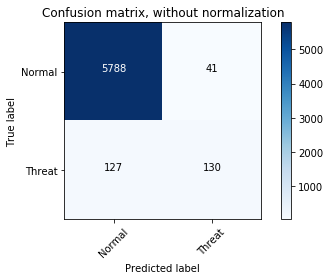

In [40]:
class_names = ['Normal','Threat']
# Plot non-normalized confusion matrix
plot_confusion_matrix(cm, classes=class_names,title='Confusion matrix, without normalization')
plt.show()

Normalized confusion matrix
[[0.9929662  0.0070338 ]
 [0.49416342 0.50583658]]


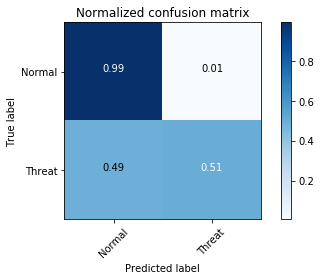

In [41]:
# Plot normalized confusion matrix
plot_confusion_matrix(cm, classes=class_names, normalize=True,title='Normalized confusion matrix')
plt.show()

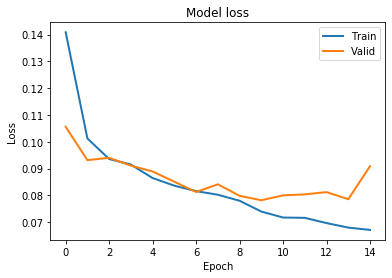

In [42]:
plt.plot(history.history['loss'], linewidth=2, label='Train')
plt.plot(history.history['val_loss'], linewidth=2, label='Valid')
plt.legend(loc='upper right')
plt.title('Model loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.show()

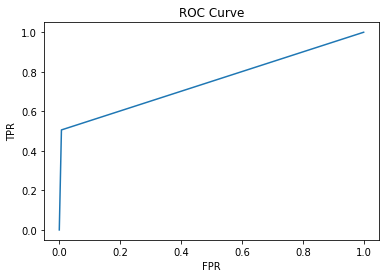

AUC: 0.749401389670459


In [43]:
from sklearn import metrics

fpr, tpr, thresholds = metrics.roc_curve(y_eval, y_pred)

# Print ROC curve
plt.title("ROC Curve")
plt.xlabel("FPR")
plt.ylabel("TPR")
plt.plot(fpr,tpr)
plt.show() 


# Print AUC
auc = np.trapz(tpr,fpr)
print('AUC:', auc)